<a href="https://colab.research.google.com/github/bhusserl-davis/ECS171-Group1-Project/blob/main/project_word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [46]:
# Download Needed Packages
import sys
!{sys.executable} -m pip install -q pandas
!{sys.executable} -m pip install -q nltk
!{sys.executable} -m pip install -q sklearn
!{sys.executable} -m pip install -q wordcloud==1.8.1
!{sys.executable} -m pip install -q gensim==3.8.3


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Jaden\\AppData\\Local\\Programs\\Python\\Python39\\Lib\\site-packages\\~ensim\\corpora\\_mmreader.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Import needed libraries and download needed data
import string
import pandas as pd
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
nltk.download('punkt', quiet=True)
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

## Data Exploration

In [4]:
# Import Data
df = pd.read_csv("./fake_job_postings.csv")
print(f'{df.shape[0]} observations, {df.shape[1]} features')
display(df.head(5))

17880 observations, 18 features


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [5]:
# Print count of NaNs and type of each column
print("Column\t\t    NaNs   Type")
for column in df.columns:
    print(f'{column.ljust(20)}{str(df[column].isna().sum()).ljust(7)}{df[column].dtype}')

Column		    NaNs   Type
job_id              0      int64
title               0      object
location            346    object
department          11547  object
salary_range        15012  object
company_profile     3308   object
description         1      object
requirements        2695   object
benefits            7210   object
telecommuting       0      int64
has_company_logo    0      int64
has_questions       0      int64
employment_type     3471   object
required_experience 7050   object
required_education  8105   object
industry            4903   object
function            6455   object
fraudulent          0      int64


In [6]:
#Replacing NAN Values
new_df = df.copy()
NAN_Cols=[
    "location","department","salary_range",
    "company_profile","description","requirements",
    "benefits","employment_type","required_experience",
    "required_experience","required_education","industry","function"
]
print("Column\t\t       NaNs")
for i in NAN_Cols:
    new_df[i].fillna("",inplace=True)
print(new_df.isnull().sum())

Column		       NaNs
job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64


In [7]:
# Get numeric columns unique values
numeric_atts = ['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']
for column in numeric_atts:
    print(f'{column}: {new_df[column].unique()}')

job_id: [    1     2     3 ... 17878 17879 17880]
telecommuting: [0 1]
has_company_logo: [1 0]
has_questions: [0 1]
fraudulent: [0 1]


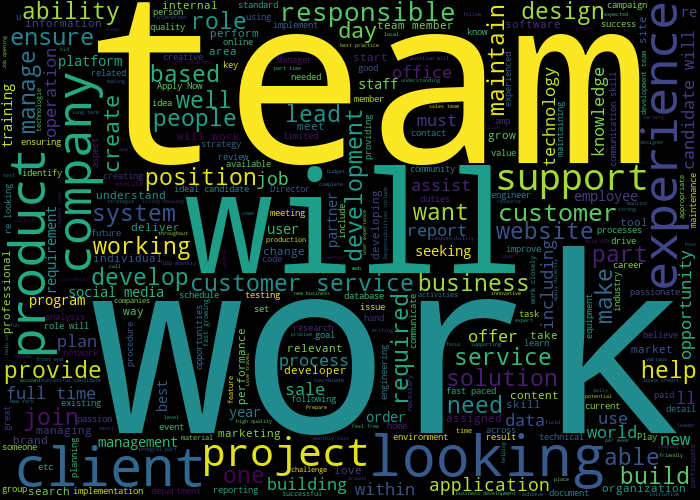

In [8]:
#Data Visualization
#top 300 most used words in the description
long_string = ','.join(list(new_df['description'].values))
wordcloud = WordCloud(background_color="black", max_words=500, width=700, height=500, contour_width=10, contour_color='green')
wordcloud.generate(long_string)
wordcloud.to_image()


In [9]:
new_df[:5]

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## Preprocessing

In [10]:
# Convert Everything to lowercase
new_df = new_df.applymap(lambda s: s.lower() if type(s) == str else s)
display(new_df.head(5))

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,marketing intern,"us, ny, new york",marketing,,"we're food52, and we've created a groundbreaki...","food52, a fast-growing, james beard award-winn...",experience with content management systems a m...,,0,1,0,other,internship,,,marketing,0
1,2,customer service - cloud video production,"nz, , auckland",success,,"90 seconds, the worlds cloud video production ...",organised - focused - vibrant - awesome!do you...,what we expect from you:your key responsibilit...,what you will get from usthrough being part of...,0,1,0,full-time,not applicable,,marketing and advertising,customer service,0
2,3,commissioning machinery assistant (cma),"us, ia, wever",,,valor services provides workforce solutions th...,"our client, located in houston, is actively se...",implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0
3,4,account executive - washington dc,"us, dc, washington",sales,,our passion for improving quality of life thro...,the company: esri – environmental systems rese...,"education: bachelor’s or master’s in gis, busi...",our culture is anything but corporate—we have ...,0,1,0,full-time,mid-senior level,bachelor's degree,computer software,sales,0
4,5,bill review manager,"us, fl, fort worth",,,spotsource solutions llc is a global human cap...,job title: itemization review managerlocation:...,qualifications:rn license in the state of texa...,full benefits offered,0,1,1,full-time,mid-senior level,bachelor's degree,hospital & health care,health care provider,0


In [11]:
# Remove Punctuation
punc_list = list(string.punctuation)
def remove_punctuation(text, punct_list):
    for punc in punct_list:
        if punc in text:
            text = text.replace(punc, ' ')
    return text

new_df = new_df.applymap(lambda s: remove_punctuation(s, punc_list) if type(s) == str else s)
display(new_df.head(5))

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,marketing intern,us ny new york,marketing,,we re food52 and we ve created a groundbreaki...,food52 a fast growing james beard award winn...,experience with content management systems a m...,,0,1,0,other,internship,,,marketing,0
1,2,customer service cloud video production,nz auckland,success,,90 seconds the worlds cloud video production ...,organised focused vibrant awesome do you...,what we expect from you your key responsibilit...,what you will get from usthrough being part of...,0,1,0,full time,not applicable,,marketing and advertising,customer service,0
2,3,commissioning machinery assistant cma,us ia wever,,,valor services provides workforce solutions th...,our client located in houston is actively se...,implement pre commissioning and commissioning ...,,0,1,0,,,,,,0
3,4,account executive washington dc,us dc washington,sales,,our passion for improving quality of life thro...,the company esri – environmental systems rese...,education bachelor’s or master’s in gis busi...,our culture is anything but corporate—we have ...,0,1,0,full time,mid senior level,bachelor s degree,computer software,sales,0
4,5,bill review manager,us fl fort worth,,,spotsource solutions llc is a global human cap...,job title itemization review managerlocation ...,qualifications rn license in the state of texa...,full benefits offered,0,1,1,full time,mid senior level,bachelor s degree,hospital health care,health care provider,0


In [12]:
# Tokenize each text column
token_df = new_df.copy()
for column in new_df.columns:
    token_df[column] = new_df[column].apply(lambda s: word_tokenize(s) if type(s) == str else s)
display(token_df.head(5))

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,"[marketing, intern]","[us, ny, new, york]",[marketing],[],"[we, re, food52, and, we, ve, created, a, grou...","[food52, a, fast, growing, james, beard, award...","[experience, with, content, management, system...",[],0,1,0,[other],[internship],[],[],[marketing],0
1,2,"[customer, service, cloud, video, production]","[nz, auckland]",[success],[],"[90, seconds, the, worlds, cloud, video, produ...","[organised, focused, vibrant, awesome, do, you...","[what, we, expect, from, you, your, key, respo...","[what, you, will, get, from, usthrough, being,...",0,1,0,"[full, time]","[not, applicable]",[],"[marketing, and, advertising]","[customer, service]",0
2,3,"[commissioning, machinery, assistant, cma]","[us, ia, wever]",[],[],"[valor, services, provides, workforce, solutio...","[our, client, located, in, houston, is, active...","[implement, pre, commissioning, and, commissio...",[],0,1,0,[],[],[],[],[],0
3,4,"[account, executive, washington, dc]","[us, dc, washington]",[sales],[],"[our, passion, for, improving, quality, of, li...","[the, company, esri, –, environmental, systems...","[education, bachelor, ’, s, or, master, ’, s, ...","[our, culture, is, anything, but, corporate—we...",0,1,0,"[full, time]","[mid, senior, level]","[bachelor, s, degree]","[computer, software]",[sales],0
4,5,"[bill, review, manager]","[us, fl, fort, worth]",[],[],"[spotsource, solutions, llc, is, a, global, hu...","[job, title, itemization, review, managerlocat...","[qualifications, rn, license, in, the, state, ...","[full, benefits, offered]",0,1,1,"[full, time]","[mid, senior, level]","[bachelor, s, degree]","[hospital, health, care]","[health, care, provider]",0


In [47]:
import gensim

In [48]:
sentence = token_df['description']

In [49]:
print(type(sentence))
print(sentence.shape)
print(sentence)

<class 'pandas.core.series.Series'>
(17880,)
0        [food52, a, fast, growing, james, beard, award...
1        [organised, focused, vibrant, awesome, do, you...
2        [our, client, located, in, houston, is, active...
3        [the, company, esri, –, environmental, systems...
4        [job, title, itemization, review, managerlocat...
                               ...                        
17875    [just, in, case, this, is, the, first, time, y...
17876    [the, payroll, accountant, will, focus, primar...
17877    [experienced, project, cost, control, staff, e...
17878    [nemsia, studios, is, looking, for, an, experi...
17879    [who, are, we, vend, is, an, award, winning, w...
Name: description, Length: 17880, dtype: object


In [50]:
sentence[1][:5]

['organised', 'focused', 'vibrant', 'awesome', 'do']

In [51]:
'reproducing' in sentence[0]

True

In [54]:
w2v_model = gensim.models.Word2Vec(sentence,min_count=1,vector_size=100)

In [55]:
print(w2v_model.wv["reproducing"])

TypeError: 'Word2Vec' object is not subscriptable

In [56]:
def most_similar(w2v_model, words, topn=10):
    similar_df = pd.DataFrame()
    for word in words:
        try:
            similar_words = pd.DataFrame(w2v_model.wv.most_similar(word, topn=topn), columns=[word, 'cos'])
            similar_df = pd.concat([similar_df, similar_words], axis=1)
        except:
            print(word, "not found in Word2Vec model!")
    return similar_df

In [57]:
most_similar(w2v_model,['our','title','client','company'])

,our,cos,title,cos,client,cos,company,cos
0,its,0.656316,assistantdescriptionan,0.627040,customer,0.672452,organization,0.660274
1,the,0.563998,jr,0.622232,clients,0.617551,organisation,0.586080
2,their,0.509510,summary,0.609311,miningparticipate,0.491811,firm,0.538054
3,global,0.436291,descriptionthe,0.588979,customers,0.487751,agency,0.483174
4,timesunderstand,0.417966,descriptionadministrative,0.583405,employee,0.476231,communityworking,0.460687
5,success,0.412172,assitant,0.571505,vendor,0.473092,startup,0.458826
6,bioinformaticscontribute,0.401152,loansassistance,0.553763,stakeholder,0.467051,department,0.444099
7,us,0.395892,description,0.553628,restrictionsmanage,0.441740,industry,0.439442
8,this,0.390817,managementduration,0.553369,strategic,0.439503,group,0.430432
9,innovative,0.381923,vfabric,0.552576,partner,0.437867,nuesoft,0.428693


## Model Training

In [58]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [59]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(token_df['description'])

X = tokenizer.texts_to_sequences(token_df['description'])

In [60]:
X[0][:10]

[3025, 5, 149, 96, 5426, 7320, 808, 759, 173, 547]

In [61]:
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break    

and -> 1
the -> 2
to -> 3
of -> 4
a -> 5
in -> 6
for -> 7
with -> 8
you -> 9
our -> 10


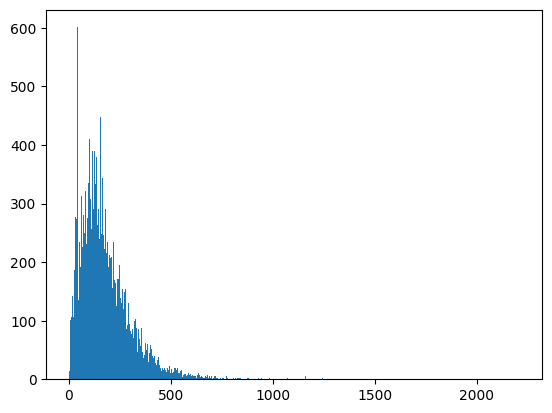

In [63]:
import matplotlib.pyplot as plt
plt.hist([len(x) for x in X], bins=500)
plt.show()

In [64]:
import numpy as np
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])


17772

In [65]:
#Lets keep all news to 700, add padding to news with less than 700 words and truncating long ones
maxlen = 700 

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [66]:
#all news has 700 words (in numerical form now). If they had less words, they have been padded with 0
# 0 is not associated to any word, as mapping of words started from 1
# 0 will also be used later, if unknows word is encountered in test set
len(X[0])

700

In [67]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [68]:
EMBEDDING_DIM = 100

In [72]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [73]:
print(type(word_index))
print(word_index["reproducing"])
print(w2v_model)

<class 'dict'>
15409
Word2Vec<vocab=64298, vector_size=100, alpha=0.025>


In [74]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [75]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


del embedding_vectors

In [76]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 100)          6429900   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 6,547,277
Trainable params: 117,377
Non-trainable params: 6,429,900
_________________________________________________________________


In [77]:
y = df['fraudulent']

In [78]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [79]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
294/294 [==============================] - 140s 471ms/step - loss: 0.1694 - acc: 0.9543 - val_loss: 0.1501 - val_acc: 0.9587
Epoch 2/6
294/294 [==============================] - 136s 464ms/step - loss: 0.1230 - acc: 0.9650 - val_loss: 0.1335 - val_acc: 0.9637
Epoch 3/6
176/294 [================>.............] - ETA: 47s - loss: 0.0912 - acc: 0.9734

KeyboardInterrupt: 

In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")

140/140 [==============================] - 2s 13ms/step


In [ ]:
classification_report(y_test, y_pred)

NameError: name 'accuracy_score' is not defined

reference
- https://stackoverflow.com/questions/43066071/replace-numpy-nan-with-string-in-list-with-strings
- https://www.kaggle.com/code/jerrykuo7727/word2vec
- https://www.kaggle.com/code/atishadhikari/fake-news-cleaning-word2vec-lstm-99-accuracy